In [130]:
import torch
import transformers
from ast import literal_eval
import pandas as pd
import random
import numpy as np
import chardet

In [131]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('train.csv')

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

In [43]:
dataset = pd.read_csv('test.csv')

In [44]:
len(dataset)

869

In [45]:
df['choices']

0                                [ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]
1       [고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...
2       [이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...
3       [살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...
4       [사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....
                              ...                        
2026               [1억8760만달러, 5000만달러, 2억달러, 1억달러, 3억달러]
2027    [전시물 설명 및 안내, 고객 서비스 제공, 제품 판매 촉진, 온라인 강좌 콘텐츠 ...
2028    [옥수동의 재개발이 먼저 이루어졌다, 금호동의 인구가 더 많다, 옥수동이 더 많은 ...
2029                      [셀트리온, 삼성전자, LG화학, 한화그룹, 현대자동차]
2030                                [자애, 연민, 기쁨, 평온, 소유욕]
Name: choices, Length: 2031, dtype: object

In [46]:
print(df['choices'].head())
print(type(df['choices'].iloc[0]))

0                             [ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]
1    [고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...
2    [이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...
3    [살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...
4    [사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....
Name: choices, dtype: object
<class 'list'>


In [47]:
len(df)

2031

In [48]:
print(df.isnull().sum())

id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


In [50]:
print(df[df['question'].notnull()])

                           id  \
0      generation-for-nlp-425   
1      generation-for-nlp-426   
2      generation-for-nlp-427   
3      generation-for-nlp-428   
4      generation-for-nlp-429   
...                       ...   
2026  generation-for-nlp-2893   
2027  generation-for-nlp-2894   
2028  generation-for-nlp-2895   
2029  generation-for-nlp-2896   
2030  generation-for-nlp-2899   

                                              paragraph  \
0     상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...   
1     (가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...   
2     나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...   
3     이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....   
4     선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...   
...                                                 ...   
2026  “헐값에 팔리는 냉동 오렌지주스만 잔뜩 사가고, 쿠폰을 오려 모았으며, 구멍 난 스...   
2027  넷기어코리아(지사장 김진겸, 이하 넷기어)가 뮤럴 캔버스를 가지고 넷기어 SNS에서...   
2028  서울 성동구 옥수동과 금호동은 맞붙어 있는 동네지만 아파트값은 같은 면적에서 1억원...   
2029  방하남 고용노

In [51]:
# Combine 'question' and 'question_plus' if available
question_df = pd.DataFrame()
question_df['question_plus'] = df['question_plus'].fillna('')
question_df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
question_df['question_length'] = question_df['full_question'].apply(len)

In [52]:
question_df

,question_plus,full_question,question_length
0,,상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,37
1,,(가)에 대한 설명으로 옳지 않은 것은?,22
2,,(가) 지역에 대한 설명으로 옳은 것은?,22
3,,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,24
4,,(가) 인물이 추진한 정책으로 옳지 않은 것은?,26
...,...,...,...
2026,,잭 맥도널드가 남긴 유산의 총액은 얼마인가?,24
2027,,넷기어가 모집하는 '뮤럴 공식 도슨트'의 주요 역할은 무엇인가?,35
2028,,옥수동과 금호동의 아파트값 차이가 발생한 주된 이유는 무엇인가?,35
2029,,방하남 고용노동부 장관이 방문한 기업의 이름은 무엇인가?,31


In [53]:
import matplotlib.pyplot as plt

In [54]:
# 'question'과 'question_plus'를 결합한 데이터 길이 평균

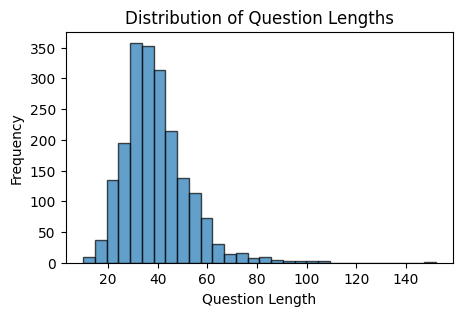

In [55]:
plt.figure(figsize=(5, 3))
plt.hist(question_df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

In [56]:
# question_plus 컬럼에 값이 있는지 여부 확인
has_values = df['question_plus'].notna().sum()
print(f"Rows with values in 'question_plus': {has_values}")


Rows with values in 'question_plus': 0


In [57]:
# 평균, 최대, 최소 길이 계산
average_length1 = df['question'].str.len().mean()
max_length1 = df['question'].str.len().max()
min_length1 = df['question'].str.len().min()

# 결과 출력
print(f"평균 길이: {average_length1}")
print(f"가장 긴 길이: {max_length1}")
print(f"가장 짧은 길이: {min_length1}")

평균 길이: 39.24175283111768
가장 긴 길이: 152
가장 짧은 길이: 10


In [58]:
# question_plus 컬럼의 값 분포 확인
print(df['question_plus'].value_counts())


Series([], Name: count, dtype: int64)


In [59]:
#결과
"""
일반적으로 value_counts()는 고유 값의 빈도를 나타내줌
하지만 하나의 값만 나타나고 있음을 알 수 있음
각 값이 고유해서 각각 1번씩만 나타난다는 의미
결과의 데이터 타입이 정수형
"""

'\n일반적으로 value_counts()는 고유 값의 빈도를 나타내줌\n하지만 하나의 값만 나타나고 있음을 알 수 있음\n각 값이 고유해서 각각 1번씩만 나타난다는 의미\n결과의 데이터 타입이 정수형\n'

---

# paragraph의 문자 길이 분포도


In [60]:
# 평균, 최대, 최소 길이 계산
average_length = df['paragraph'].str.len().mean()
max_length = df['paragraph'].str.len().max()
min_length = df['paragraph'].str.len().min()

# 결과 출력
print(f"평균 길이: {average_length}")
print(f"가장 긴 길이: {max_length}")
print(f"가장 짧은 길이: {min_length}")


평균 길이: 735.3244707040867
가장 긴 길이: 2017
가장 짧은 길이: 15


In [61]:
longest_context = df.loc[df['paragraph'].str.len().idxmax(), 'paragraph']
shortest_context = df.loc[df['paragraph'].str.len().idxmin(), 'paragraph']

print("Longest context:")
print(longest_context)
print("\nShortest context:")
print(shortest_context)


Longest context:
서울시가 2030년까지 ‘4대문 안 한양도성’과 ‘강남’ ‘영등포·여의도’ 등을 국제경쟁력을 갖춘 ‘3대 도심권’으로 육성한다는 계획을 세웠다. 또 용산, 청량리·왕십리, 창동·상계 등 7개 권역은 이를 둘러싼 ‘광역중심(옛 부도심)’으로 지정하고 지역별 특성에 맞게 개발키로 했다. 서울시는 26일 이 같은 내용을 핵심으로 한 ‘2030 도시기본계획안(서울플랜)’을 발표했다. 지역별 균형발전을 위한 ‘권역별 거점지역’을 확대하고, 여기에 맞는 급행철도 등 광역교통망을 확충하는 마스터플랜을 담고 있다. ○강남·여의도 ‘도심권’ 추가 지정이번 서울도시기본계획은 1990년 첫 계획이 마련된 이후 ‘2020 서울도시기본계획’까지 20여년간 유지됐던 기본 골격(1도심·5부도심·11지역중심)을 ‘3도심·7광역중심·12지역중심’으로 바꿨다. 지금까지는 서울의 한복판인 ‘4대문 안 일대’를 핵심축(1도심)으로 도시체계가 짜여졌지만 앞으로는 핵심 도시권을 2개 더 추가해 강남·북을 아우르는 ‘3각 도심’ 체계로 전환하겠다는 것이다. 3대 도심은 각자 특성을 반영해 각종 개발계획이 세워진다. 4대문 안은 ‘세계적 역사문화중심지’로, 강남과 영등포·여의도는 각각 ‘국제업무중심지’ ‘국제금융중심지’로 특화한다. 도심권을 둘러싼 ‘5대 부도심권’은 ‘7개 광역중심’이란 명칭을 붙여 2개권을 추가했다. 다른 지역에 비해 낙후된 동북·서남권에 1곳씩을 더했다. 해당 지역은 용산, 청량리·왕십리, 상암·수색, 창동·상계, 가산·대림, 잠실, 마곡 등이다. 광역중심지는 창동차량기지와 마곡산업단지, 구로차량기지, 제2롯데월드 등 대규모 개발과 고용 창출이 가능한 지역들을 지정했다. 광역중심의 하부 개념인 ‘지역중심은 12곳으로 구분됐다. 동대문, 성수, 망우, 미아, 연신내·불광, 신촌, 마포·공덕, 목동, 봉천, 사당·이수, 수서·문정, 천호·길동 등이다. 이들 지역에는 각종 공공서비스 및 상업·문화기능 확대를 통해 자족기능이 가능해지도록 개발 지원이 이뤄진다

In [62]:
row = df.loc[217]
print(row)

id                                          generation-for-nlp-692
paragraph                                          재정 정책     통화 정책
question           다음 중 긴축적 재정 정책과 확장적 통화 정책의 조합을 나타내는 것은 어느 것입니까?
choices          [세금 인상     국채 매각, 세금 인하     국채 매입, 정부 지출 감소   ...
answer                                                           4
question_plus                                                 None
Name: 217, dtype: object


In [63]:
# 문단 길이 계산
paragraph_df = pd.DataFrame()
paragraph_df = df['paragraph'].str.len()


In [64]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


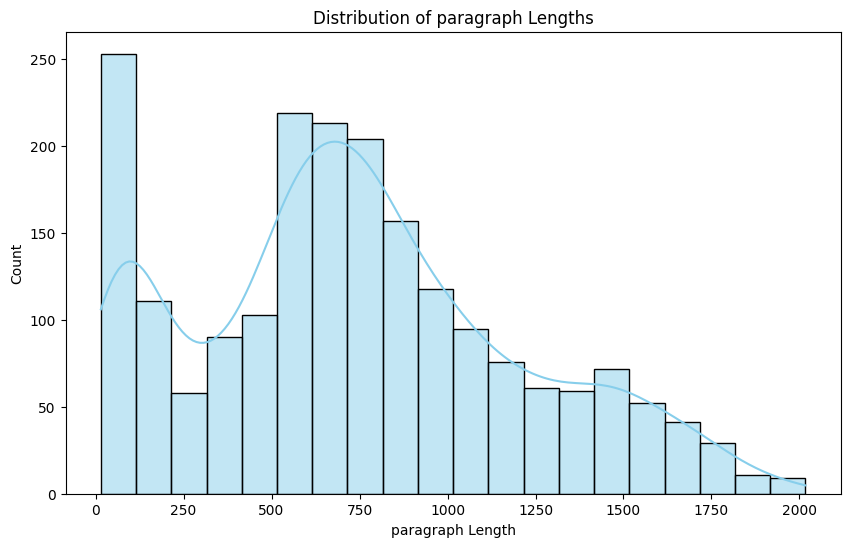

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 및 KDE 시각화
plt.figure(figsize=(10, 6))
sns.histplot(paragraph_df, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of paragraph Lengths')
plt.xlabel('paragraph Length')
plt.show()

In [66]:
# 'paragraph' 열의 값별로 그룹화하고, 2개 이상의 행을 가진 그룹만 선택
duplicates = df[df.duplicated(subset=['paragraph'], keep=False)]

# 'paragraph' 열로 정렬하여 중복된 행들을 연속해서 볼 수 있게 함
duplicates_sorted = duplicates.sort_values('paragraph')
duplicates_sorted

,id,paragraph,question,choices,answer,question_plus
157,generation-for-nlp-611,"""1500년 에라스무스가 도버에서 불행을 겪고 집필하여 마운트조이에게 헌정한 작품인...",이 지문에 나타난 정보는 무엇입니까?,"[그러한 특성을 중요히 여기는 20세기 유럽인으로서의 작가의 삶, 에라스무스의 작업...",1,None
118,generation-for-nlp-564,"""1500년 에라스무스가 도버에서 불행을 겪고 집필하여 마운트조이에게 헌정한 작품인...",이 구절에서 에라스무스의 인본주의 유형과 가장 유사한 남부 르네상스 운동은?,"[신플라톤주의, 반삼위일체론, 경건주의, 이성주의]",1,None
187,generation-for-nlp-657,"""공산주의라는 유령 하나가 유럽을 떠돌고 있다. 교황과 차르, 메테르니히와 기조, ...",현대 역사가들은 이 팜플렛의 출판 시기가 다음 중 어떤 사건과 시기가 일치한다고 기...,"[같은 해 유럽을 휩쓴 일련의 혁명, 그리스 반도에 대한 오스만 제국의 압력 증가,...",1,None
137,generation-for-nlp-585,"""공산주의라는 유령 하나가 유럽을 떠돌고 있다. 교황과 차르, 메테르니히와 기조, ...",1917년 즈음 이 선전문에 있는 어떤 사상이 러시아에서 현실이 되었습니까?,"[외국 동맹과 얽히는 일 피하기, 프롤레타리아에 의한 폭력적인 부르주아 타도, 강력...",2,None
85,generation-for-nlp-527,"""공산주의라는 유령 하나가 유럽을 떠돌고 있다. 교황과 차르, 메테르니히와 기조, ...",이 글에서 마르크스와 엥겔스가 천착하고 있는 것으로 보이는 것은 무엇입니까?,"[두려움을 유발해 독자들로 하여금 행동하게 만드는 것, 운동 전체를 수포로 만들 위...",4,None
...,...,...,...,...,...,...
505,generation-for-nlp-1034,하지만 전 우리 역사의 이 특별한 순간 시민의 자유가 중요함을 누구보다 더 잘 알고...,루즈벨트의 우려는 다음 중 어떤 사안에 대해 토론한 사람들의 우려와 가장 직접 비견...,"[1964년 통킹만 결의, 1965년 투표권법, 2001년 미국 애국법, 2010년...",3,None
615,generation-for-nlp-1170,해외 국가들은 옛날의 그 국가가 아닙니다. 그들은 증기선을 발명했고 항해술도 혁신적...,이이 주군의 염려와 가장 관련이 깊은 일본 역사의 사건 또는 시대는 무엇입니까?,"[일본의 기독교 선교사 추방, 일본 황실의 중국 황실 관습 채택, 일본의 만주 합병...",4,None
644,generation-for-nlp-1204,해외 국가들은 옛날의 그 국가가 아닙니다. 그들은 증기선을 발명했고 항해술도 혁신적...,이 시기에 이이 주군이 제기한 우려에 일본은 어떻게 대응했습니까?,"[정부가 중국 스타일의 공무원 조직 시스템을 해체함., 정부가 태평양에서 정복 프로...",3,None
789,generation-for-nlp-1375,화약 무기: 유럽 vs. 중국 1200년대부터 1400년대까지 서유럽의 초기 대포는...,이 구절은 세계사에 대한 어떤 전통적인 관점에 도전하고 있는가?,"[중국은 항상 대부분의 아프리카-유라시아 사회보다 기술적으로 덜 발전했다, 중국의 ...",4,None


In [71]:
pip install --upgrade datasets

Note: you may need to restart the kernel to use updated packages.


In [72]:
import sys
from datasets import Dataset

In [73]:
dataset = Dataset.from_pandas(df)

In [74]:
dataset

Dataset({
    features: ['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus'],
    num_rows: 2031
})

In [75]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [76]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )


In [77]:
processed_dataset[0]

{'id': 'generation-for-nlp-425',
 'messages': [{'role': 'system', 'content': '지문을 읽고 질문의 답을 구하세요.'},
  {'role': 'user',
   'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:'},
  {'role': 'assistant', 'content': '2'}],
 'label': 2}

In [78]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 2031
})

In [79]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [80]:
tokenizer = AutoTokenizer.from_pretrained(
    "beomi/gemma-ko-2b",
    trust_remote_code=True,
)

In [81]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


In [82]:
tokenizer.chat_template = "{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>\n' }}{% endif %}{% endfor %}"

In [83]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

In [84]:
total_samples = len(tokenized_dataset)
print(f"전체 샘플 수: {total_samples}")

전체 샘플 수: 2031


In [85]:
long_samples = tokenized_dataset.filter(lambda x: len(x["input_ids"]) > 1024)
long_samples_count = len(long_samples)
print(f"1024 토큰 초과 샘플 수: {long_samples_count}")

Filter:   0%|          | 0/2031 [00:00<?, ? examples/s]

1024 토큰 초과 샘플 수: 367


In [86]:
long_samples_ratio = (long_samples_count / total_samples) * 100
print(f"1024 토큰 초과 샘플 비율: {long_samples_ratio:.2f}%")

1024 토큰 초과 샘플 비율: 18.07%


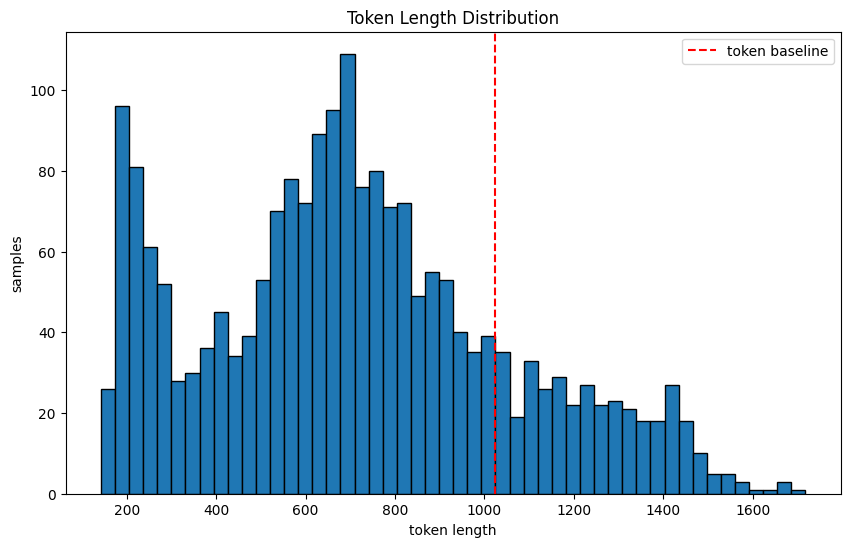

In [87]:
import matplotlib.pyplot as plt

token_lengths = [len(sample["input_ids"]) for sample in tokenized_dataset]

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, edgecolor='black')
plt.title('Token Length Distribution')
plt.xlabel('token length')
plt.ylabel('samples')
plt.axvline(x=1024, color='r', linestyle='--', label='token baseline')
plt.legend()
plt.show()

# 정리
중복된 지문 282 rows 존재

결측치(문자열, 공백, NULL,특수문자) 확인결과 결측치 X

지문 길이의 분포도 paragraph(지문) length 2000자가 제일 적은 상태로 보임

In [88]:
# 추가 확인 해볼 것들
'''
주제별 분석
paragraph에서 특정 시대나 주제를 추출하여 분류
주제별 문제 유형 및 난이도 분석

국어와 사회 문제의 데이터 밸런스를 맞춰 제작(주제 분류가 필요한가?)


국어 영역
독서, 문학 기본
선택
(화법, 작문), (언어, 매체)

사회탐구 영역 8개 중에 두가지 영역 선택
생활과 윤리, 윤리와 사상, 한국지리, 세계지리, 동아시아사, 세계사, 경제, 정치와 법, 사회･문화의 과목으로 구성된다.
'''

'\n주제별 분석\nparagraph에서 특정 시대나 주제를 추출하여 분류\n주제별 문제 유형 및 난이도 분석\n\n국어와 사회 문제의 데이터 밸런스를 맞춰 제작(주제 분류가 필요한가?)\n\n\n국어 영역\n독서, 문학 기본\n선택\n(화법, 작문), (언어, 매체)\n\n사회탐구 영역 8개 중에 두가지 영역 선택\n생활과 윤리, 윤리와 사상, 한국지리, 세계지리, 동아시아사, 세계사, 경제, 정치와 법, 사회･문화의 과목으로 구성된다.\n'

In [89]:
pip install konlpy

  Obtaining dependency information for konlpy from https://files.pythonhosted.org/packages/5a/95/896914d9461c12f07e6f8afb1f7462e28395fc46b54fcbb96f1ea3cff8fb/konlpy-0.6.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for JPype1>=0.7.0 from https://files.pythonhosted.org/packages/74/98/d6517002355b0585d0e66f7b0283c7f6e2271c898a886e1ebac09836b100/JPype1-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for lxml>=4.1.0 from https://files.pythonhosted.org/packages/05/9e/87492d03ff604fbf656ed2bf3e2e8d28f5d58ea1f00ff27ac27b06509079/lxml-5.3.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 11.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [90]:
from konlpy.tag import Okt
from collections import Counter


In [91]:
# Convert to DataFrame
df = pd.DataFrame(records)

In [ ]:
okt = Okt() # 형태소 초기화

In [ ]:
# 불용어 리스트 (필요에 따라 확장 예정)
stop_words = ['이', '그', '저', '것', '수', '등', '및', '에서', '그리고', '있다', '하다']

In [ ]:
def preprocess_text(text):
    # 형태소 분석 및 명사 추출
    nouns = okt.nouns(text)
    # 불용어 제거 및 길이가 1인 단어 제거
    nouns = [word for word in nouns if word not in stop_words and len(word) > 1]
    return nouns

In [ ]:
all_nouns = []
for text in df['paragraph']:
    all_nouns.extend(preprocess_text(text))

In [ ]:
# 단어 빈도 계산
word_freq = Counter(all_nouns)

# 상위 단어 추출
top_words = dict(word_freq.most_common(10))

In [ ]:
top_words

---
# choices에 대한 결측치

In [ ]:
# 전체 데이터프레임의 'choices' 열에 대해 선택지 개수 확인
choices_counts = duplicates_sorted['choices'].apply(len)

# 선택지 개수별 빈도 확인
frequency = choices_counts.value_counts().sort_index()
print("선택지 개수별 빈도:")
print(frequency)

# 백분율 계산
percentage = (frequency / len(duplicates_sorted)) * 100
print("\n선택지 개수별 백분율:")
print(percentage)

# 요약 통계
print("\n요약 통계:")
print(choices_counts.describe())

# 4지선다와 5지선다의 비율
four_choices = (choices_counts == 4).sum()
five_choices = (choices_counts == 5).sum()
total = len(choices_counts)

print(f"\n4지선다 비율: {four_choices/total:.2%}")
print(f"5지선다 비율: {five_choices/total:.2%}")

선택지 개수별 빈도:
choices
4    282
Name: count, dtype: int64

선택지 개수별 백분율:
choices
4    100.0
Name: count, dtype: float64

요약 통계:
count    282.0
mean       4.0
std        0.0
min        4.0
25%        4.0
50%        4.0
75%        4.0
max        4.0
Name: choices, dtype: float64

4지선다 비율: 100.00%
5지선다 비율: 0.00%


In [ ]:
#choices 자체에 이미 4지선다로 이루어져 있음
#추후 데이터 증강 및 데이터 수정시
#증강으로 5지선다 정답 값을 늘릴 것인지 혹은 4지선다를 5지선다로 늘려 정답값 위치를 수정할 것인지

In [ ]:
# 'duplicate_paragraphs' 데이터프레임을 CSV 파일로 저장
duplicates_sorted.to_csv('duplicate_paragraphs.csv', index=False, encoding='utf-8-sig')

---

# 문제 유형 분석(question열)

In [151]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# 데이터 로드 (CSV 파일로 저장되어 있다고 가정)
df = pd.DataFrame(records)

### Question 등장 횟수 

In [ ]:
# 1. 문제 빈도 분석
def question_type_analysis(df):
    question_types = df['question'].apply(lambda x: x.split('?')[0] + '?')
    type_counts = Counter(question_types)
    return pd.DataFrame(type_counts.items(), columns=['Question Type', 'Frequency']).sort_values('Frequency', ascending=False)

In [136]:
question_types = question_type_analysis(df)

In [137]:
question_types

,Question Type,Frequency
101,이 지문에 나타난 정보는 무엇입니까?,15
296,여기에 해당하지 않는 것은 무엇입니까?,5
472,이 지문에 나타난 정보는 무엇인가?,5
6,다음 사건을 시기 순으로 바르게 나열한 것은?,4
33,밑줄 친 ‘왕’의 재위 기간에 있었던 일로 옳은 것은?,4
...,...,...
660,다음 중 위 헌법이 제정된 데에 가장 직접적인 책임이 있는 것은?,1
659,다음 중 첫 번째 편지의 어조를 가장 잘 반영한 근대 초기 아프리카의 발전 사항은?,1
658,다음 중 두 번째 문단에서 언급된 자본주의 국가들의 해외 투자로 인해 직접적으로 발...,1
657,다음 중 다섯 번째 문단에 언급된 거부 운동의 궁극적인 성공에 가장 큰 도움을 준 ...,1


In [138]:
print("질문 등장 횟수")
print(question_types.head())

질문 등장 횟수
                      Question Type  Frequency
101            이 지문에 나타난 정보는 무엇입니까?         15
296           여기에 해당하지 않는 것은 무엇입니까?          5
472             이 지문에 나타난 정보는 무엇인가?          5
6         다음 사건을 시기 순으로 바르게 나열한 것은?          4
33   밑줄 친 ‘왕’의 재위 기간에 있었던 일로 옳은 것은?          4


In [170]:
# 2. 특정 키워드나 패턴 식별
def keyword_analysis(df):
    keywords = ['옳은', '않은', '틀린', '다른','나열', '빈칸','무엇입니까']
    keyword_counts = {keyword: df['question'].str.count(keyword).sum() for keyword in keywords}
    return pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count']).sort_values('Count', ascending=False)

In [171]:
keyword_counts = keyword_analysis(df)

In [174]:
total_count = keyword_counts['Count'].sum()
total_count

335

In [172]:
keyword_counts

,Keyword,Count
6,무엇입니까,194
0,옳은,87
1,않은,31
4,나열,12
3,다른,11
2,틀린,0
5,빈칸,0


---

# 선택지 분석(choices)

In [175]:
df = pd.DataFrame(records)

In [176]:
df

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None
...,...,...,...,...,...,...
2026,generation-for-nlp-2893,"“헐값에 팔리는 냉동 오렌지주스만 잔뜩 사가고, 쿠폰을 오려 모았으며, 구멍 난 스...",잭 맥도널드가 남긴 유산의 총액은 얼마인가?,"[1억8760만달러, 5000만달러, 2억달러, 1억달러, 3억달러]",1,None
2027,generation-for-nlp-2894,"넷기어코리아(지사장 김진겸, 이하 넷기어)가 뮤럴 캔버스를 가지고 넷기어 SNS에서...",넷기어가 모집하는 '뮤럴 공식 도슨트'의 주요 역할은 무엇인가?,"[전시물 설명 및 안내, 고객 서비스 제공, 제품 판매 촉진, 온라인 강좌 콘텐츠 ...",4,None
2028,generation-for-nlp-2895,서울 성동구 옥수동과 금호동은 맞붙어 있는 동네지만 아파트값은 같은 면적에서 1억원...,옥수동과 금호동의 아파트값 차이가 발생한 주된 이유는 무엇인가?,"[옥수동의 재개발이 먼저 이루어졌다, 금호동의 인구가 더 많다, 옥수동이 더 많은 ...",1,None
2029,generation-for-nlp-2896,방하남 고용노동부 장관(사진)이 취임 후 첫 외부 행사로 5년 만에 일자리를 3.5...,방하남 고용노동부 장관이 방문한 기업의 이름은 무엇인가?,"[셀트리온, 삼성전자, LG화학, 한화그룹, 현대자동차]",1,None


In [180]:
import pandas as pd

# 데이터프레임에서 'choices' 열 분석
choices_length = df['choices'].apply(len)

# 최대, 최소 선택지 개수 계산
max_choices = choices_length.max()
min_choices = choices_length.min()

# 4지선다, 5지선다 개수 및 비율 계산
total_questions = len(df)
four_option_count = (choices_length == 4).sum()
five_option_count = (choices_length == 5).sum()

four_option_ratio = (four_option_count / total_questions) * 100
five_option_ratio = (five_option_count / total_questions) * 100

print(f"최대 선택지 개수: {max_choices}")
print(f"최소 선택지 개수: {min_choices}")
print(f"4지선다 개수: {four_option_count}")
print(f"5지선다 개수: {five_option_count}")
print(f"4지선다 비율: {four_option_ratio:.2f}%")
print(f"5지선다 비율: {five_option_ratio:.2f}%")


최대 선택지 개수: 5
최소 선택지 개수: 4
4지선다 개수: 792
5지선다 개수: 1239
4지선다 비율: 39.00%
5지선다 비율: 61.00%


In [178]:
# 각 선택지의 길이 계산
choice_lengths = df['choices'].apply(lambda x: [len(str(choice)) for choice in x])

# 최대, 최소, 평균 선택지 길이 계산
max_length = max(max(lengths) for lengths in choice_lengths)
min_length = min(min(lengths) for lengths in choice_lengths)
avg_length = sum(sum(lengths) for lengths in choice_lengths) / sum(len(lengths) for lengths in choice_lengths)

print(f"최대 선택지 길이: {max_length}")
print(f"최소 선택지 길이: {min_length}")
print(f"평균 선택지 길이: {avg_length:.2f}")


최대 선택지 길이: 136
최소 선택지 길이: 1
평균 선택지 길이: 13.37


# 정답 분석(answer)

Answer Distribution:
answer
1    948
2    450
3    319
4    283
5     31
Name: count, dtype: int64

Answer Ratios (%):
answer
1    46.676514
2    22.156573
3    15.706548
4    13.934023
5     1.526342
Name: count, dtype: float64


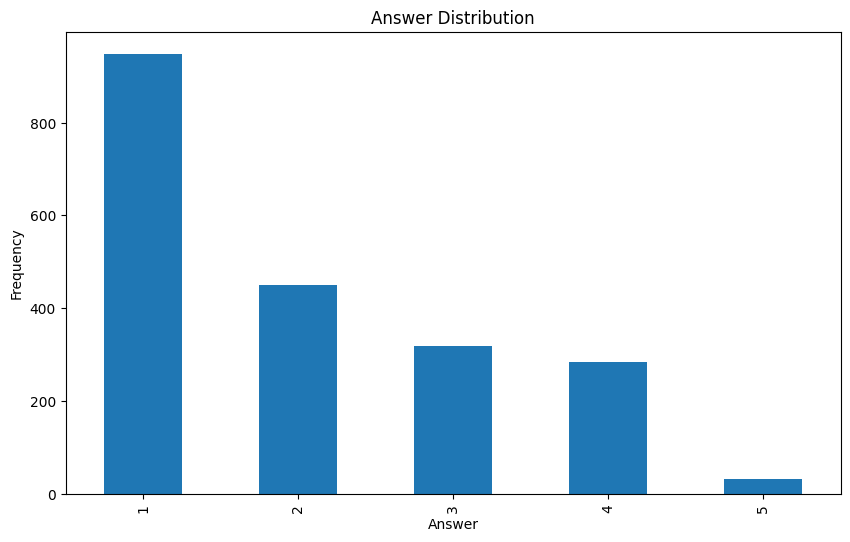

Question type column is missing. Skipping this analysis.


In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Answer Distribution Analysis
def analyze_answer_distribution(df):
    answer_counts = df['answer'].value_counts().sort_index()
    answer_ratios = (answer_counts / len(df)) * 100
    
    print("Answer Distribution:")
    print(answer_counts)
    print("\nAnswer Ratios (%):")
    print(answer_ratios)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    answer_counts.plot(kind='bar')
    plt.title('Answer Distribution')
    plt.xlabel('Answer')
    plt.ylabel('Frequency')
    plt.show()

# 2. Correlation Analysis between Answer and Question Type
def analyze_answer_type_relation(df):
    if 'type' not in df.columns:
        print("Question type column is missing. Skipping this analysis.")
        return
    
    relation = pd.crosstab(df['type'], df['answer'])
    print("Relationship between Answer and Question Type:")
    print(relation)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(relation, annot=True, cmap='YlGnBu')
    plt.title('Relationship between Answer and Question Type')
    plt.show()


# Run analyses
analyze_answer_distribution(df)
analyze_answer_type_relation(df)


Correlation coefficient between Answer and Paragraph length: -0.3048


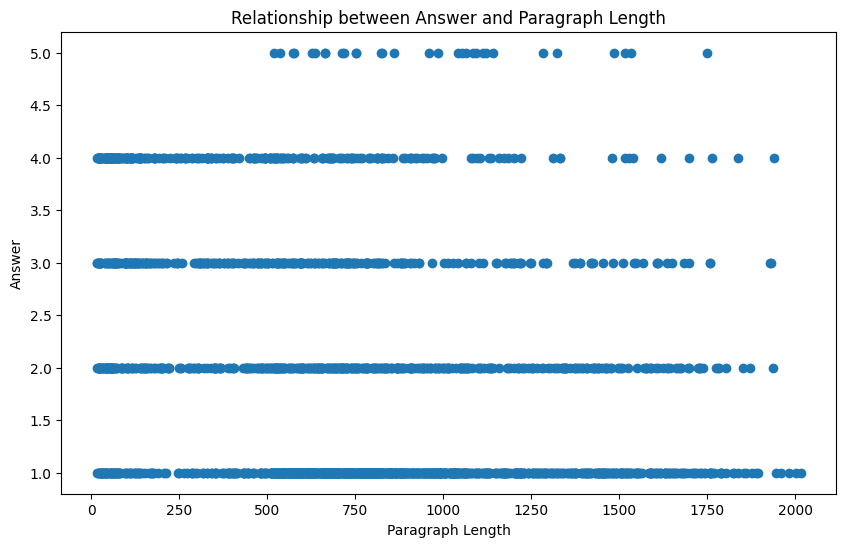

In [185]:
# 3. Correlation Analysis between Answer and Paragraph Length
def analyze_answer_paragraph_correlation(df):
    df['paragraph_length'] = df['paragraph'].str.len()
    correlation = df['answer'].corr(df['paragraph_length'])
    
    print(f"Correlation coefficient between Answer and Paragraph length: {correlation:.4f}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(df['paragraph_length'], df['answer'])
    plt.title('Relationship between Answer and Paragraph Length')
    plt.xlabel('Paragraph Length')
    plt.ylabel('Answer')
    plt.show()


analyze_answer_paragraph_correlation(df)